In [1]:
import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
%matplotlib inline

Camera Calibration

In [2]:
#gets object points
def get_objpoints(nx, ny):
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    return objp

# calibrate camera 
def calibrate_camera(nx, ny, draw = False):
    images = glob.glob(os.path.join('camera_cal/calibration*.jpg'))
    objpoints = []
    imgpoints = [] 
    for fname in images:
        image = cv2.imread(fname)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # runs on 9,6 for nx,ny. If no corners found we consider the case for a smaller values.
        #this was done because not all chessboard image corners were detected
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        objp = get_objpoints(nx, ny)
        if ret is False:
            ret, corners = cv2.findChessboardCorners(gray, (nx - 1, ny), None)
            objp = get_objpoints(nx - 1, ny)
        if ret is False:
            ret, corners = cv2.findChessboardCorners(gray, (nx, ny - 1), None)
            objp = get_objpoints(nx, ny - 1)
        if ret is False:
            ret, corners = cv2.findChessboardCorners(gray, (nx - 1, ny - 1), None)
            objp = get_objpoints(nx - 1, ny - 1)
        if ret is False:
            ret, corners = cv2.findChessboardCorners(gray, (nx - 2, ny), None)
            objp = get_objpoints(nx - 2, ny)
        if ret is False:
            ret, corners = cv2.findChessboardCorners(gray, (nx, ny - 2), None)
            objp = get_objpoints(nx, ny - 2)
        if ret is False:
            ret, corners = cv2.findChessboardCorners(gray, (nx - 2, ny - 2), None)
            objp = get_objpoints(nx - 2, ny - 2)
            
        if ret is True:
            imgpoints.append(corners)
            objpoints.append(objp)
            # If we want to draw the corners
            if draw is False:
                image = cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
                plt.figure(figsize=(5,4))
                plt.imshow(image)
                plt.show()
        else:
            print('corners not detected %s' %fname)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist

mtx, dist = calibrate_camera(nx = 9, ny = 6, draw = True)

Example of a distortion corrected calibration image.

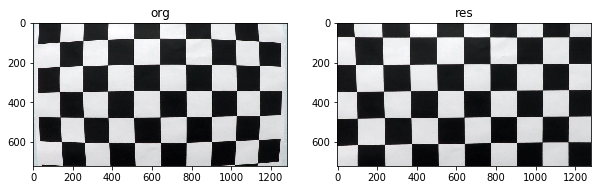

In [3]:
#distortion corrected image1
img = cv2.imread('camera_cal/calibration1.jpg')
undistorted_image = cv2.undistort(img, mtx, dist, None, mtx)
fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(img)
ax[0].set_title('org')
ax[1].imshow(undistorted_image)
ax[1].set_title('res')
plt.show()

Pipeline (test images)
1. Example of a distortion-corrected image.

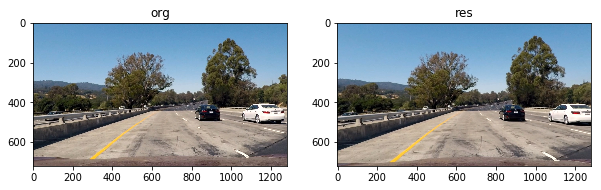

In [4]:
#distortion corrected image2
img = cv2.cvtColor(cv2.imread('test_images/test1.jpg'), cv2.COLOR_BGR2RGB)
undistorted_image = cv2.undistort(img, mtx, dist, None, mtx)
fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(img)
ax[0].set_title('org')
ax[1].imshow(undistorted_image)
ax[1].set_title('res')
plt.show()

2.Thresholded Binary Image

In [5]:
#gradient sobel in given direction
def abs_sobel_thresh(image, orient = 'x', thresh_min = 0, thresh_max = 255):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    elif orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # scale to 8 bit
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy
    binary = np.zeros_like(scaled_sobel)
    # Apply threshold
    binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary

def rgb_select(image):
    #RGB
    # White & yellow
    rgb_white = cv2.inRange(image, (200, 200, 200), (255, 255, 255))
    rgb_yellow = cv2.inRange(image, (20, 100, 100), (50, 255, 255))
    return rgb_white, rgb_yellow

def hsv_select(image):
    #HSV
    # White & yellow
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv_white = cv2.inRange(hsv, (200, 200, 200), (255, 255, 255))
    hsv_yellow = cv2.inRange(hsv, (20, 100, 100), (50, 255, 255))
    return hsv_white, hsv_yellow

def hls_schannel_select(image):
    #HLS
    # S channel
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    s_output = np.zeros_like(s)
    s_output[(s > 170) & (s <= 255)] = 1
    
    #HLS
    # White & yellow
    hls_white = cv2.inRange(hls, (200,200,200), (255,255,255))
    hls_yellow = cv2.inRange(hls, (20, 100, 100), (50, 255, 255))
    
    return s_output, hls_white, hls_yellow

def thresholding(image, s_thresh=(170, 255), sx_thresh=(30, 255)):   
    # Sobel x function 
    sobel_x = abs_sobel_thresh(image, 'x', 30, 255)
    rgb_white, rgb_yellow = rgb_select(image)
    hsv_white, hsv_yellow = hsv_select(image)
    s_output, hls_white, hls_yellow = hls_schannel_select(image)
    
    masked = sobel_x | s_output | hsv_white | hsv_yellow | hls_white | hls_yellow | rgb_white | rgb_yellow 
    return masked

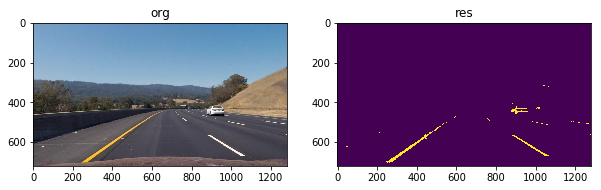

In [6]:
image = cv2.cvtColor(cv2.imread('test_images/test3.jpg'), cv2.COLOR_BGR2RGB)
undistorted_image = cv2.undistort(image, mtx, dist, None, mtx)
masked = thresholding(undistorted_image)
fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(undistorted_image)
ax[0].set_title('org')
ax[1].imshow(masked)
ax[1].set_title('res')
plt.show()

3.Perspective Transform

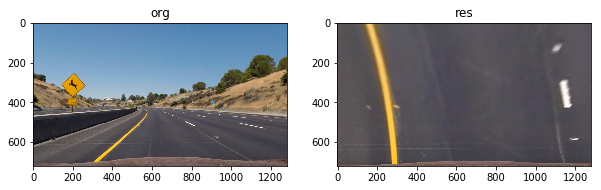

In [7]:
#Manually selected values
src = np.float32([(200,720),(1100,720),(720,470),(580,470)])
dst = np.float32([(200,720),(1100,720),(1100,0),(250,0)])

# getting M and it's inverse for perspective transform
def get_perspective_transform(src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv
 
M, Minv = get_perspective_transform(src, dst)

#display
image = cv2.cvtColor(cv2.imread('test_images/test2.jpg'), cv2.COLOR_BGR2RGB)
undistorted_image = cv2.undistort(image, mtx, dist, None, mtx)    
birdseye = cv2.warpPerspective(undistorted_image, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(undistorted_image)
ax[0].set_title('org')
ax[1].imshow(birdseye)
ax[1].set_title('res')
plt.show()

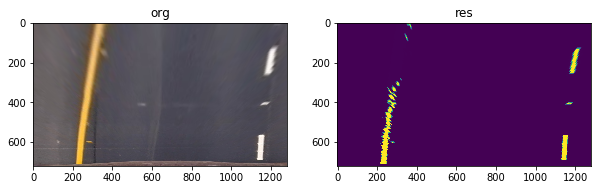

In [8]:
img = cv2.cvtColor(cv2.imread('test_images/test3.jpg'), cv2.COLOR_BGR2RGB)
undistorted_image = cv2.undistort(img, mtx, dist, None, mtx)
masked = thresholding(undistorted_image)
transformed = cv2.warpPerspective(undistorted_image, M, (1280, 720), flags=cv2.INTER_LINEAR)
binary_transformed = cv2.warpPerspective(masked, M, (1280, 720), flags=cv2.INTER_LINEAR)
fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(transformed)
ax[0].set_title('org')
ax[1].imshow(binary_transformed)
ax[1].set_title('res')
plt.show()

4. Finding lane-line pixels and fit their positions with a polynomial

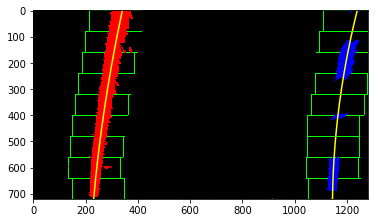

In [9]:
#lesson quiz as reference point

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img


out_img = fit_polynomial(binary_transformed)

plt.imshow(out_img)

In [10]:
#pixel to meters by approx vales given in lesson
ym_per_pix = 30/720  
xm_per_pix = 3.7/700  

# finds max val for an array
def find_max_index(array, left, right):
    max_value, max_ind = 0, 0
    for i in range(left, right):
        if array[i] > max_value:
            max_value, max_ind = array[i], i
    return max_value, max_ind

# rejects points by comparing to median
def compare_to_median(x_array, y_array):
    median = np.median(x_array)
    dev = x_array - median
    ind = []
    for i, x in enumerate(dev):
        if abs(x) > 200:
            ind.append(i)
    x_array = np.delete(x_array, ind)
    y_array = np.delete(y_array, ind)
    return x_array, y_array

class Line():
    def __init__(self):
        self.left_pts = np.array(None)
        self.right_pts = np.array(None)
        self.left_curv = 1000
        self.right_curv = 1000
    def get_lane_lines(self, img, undist, delta):
        left_lane_info = []
        right_lane_info = []
        middle = int(img.shape[1]/2)
        warped_image = np.zeros_like(img).astype(np.uint8)
        rgb_warped_image = np.dstack((warped_image, warped_image, warped_image))
        for i in range(img.shape[1] - delta, 0, -delta):
            histogram = np.sum(img[i:i+delta,:], axis = 0)
            left_max_variable, left_max_index = find_max_index(histogram, 0, middle)
            right_max_variable, right_max_index = find_max_index(histogram, middle, img.shape[1])
            if(left_max_variable > 0):
                left_lane_info.append((left_max_index, int((i+i+delta)/2)))
            if(right_max_variable > 0):
                right_lane_info.append((right_max_index, int((i+i+delta)/2)))

        left_x = np.array([item[0] for item in left_lane_info])
        left_y = np.array([item[1] for item in left_lane_info])
        left_x, left_y = compare_to_median(left_x, left_y)
        left_fit = np.polyfit(left_y, left_x, 2)
        left_extend_y = np.append(left_y, 0)
        left_extend_y = np.append(720, left_extend_y)
        left_fitx = left_fit[0]*left_extend_y**2 + left_fit[1]*left_extend_y + left_fit[2]

        right_x = np.array([item[0] for item in right_lane_info])
        right_y = np.array([item[1] for item in right_lane_info])
        right_x, right_y = compare_to_median(right_x, right_y)
        right_fit = np.polyfit(right_y, right_x, 2)
        right_extend_y = np.append(right_y, 0)
        right_extend_y = np.append(720, right_extend_y)
        right_fitx = right_fit[0]*right_extend_y**2 + right_fit[1]*right_extend_y + right_fit[2]

        # redo x and y pts for cv2.fillPoly
        pts_left = np.array([np.transpose(np.vstack([left_fitx, left_extend_y]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, right_extend_y])))])
        
        yvalue = img.shape[1]
        left_fit_cr = np.polyfit(left_y*ym_per_pix, left_x*xm_per_pix, 2)
        right_fit_cr = np.polyfit(right_y*ym_per_pix, right_x*xm_per_pix, 2)
        left_curve_radius = ((1 + (2*left_fit_cr[0]*yvalue + left_fit_cr[1])**2)**1.5) \
                                     /np.absolute(2*left_fit_cr[0])
        right_curve_radius = ((1 + (2*right_fit_cr[0]*yvalue + right_fit_cr[1])**2)**1.5) \
                                        /np.absolute(2*right_fit_cr[0])
        if left_curve_radius < 15000:
            self.left_pts = pts_left
        else:
            pts_left = self.left_pts
            left_curve_radius = self.left_curv
        
        if right_curve_radius < 15000:
            self.right_pts = pts_right
        else:
            pts_right = self.right_pts
            right_curve_radius = self.right_curv
        pts = np.hstack((pts_left, pts_right))
        cv2.fillPoly(rgb_warped_image, np.int_([pts]), (0,255, 0))
        newwarp = cv2.warpPerspective(rgb_warped_image, Minv, (img.shape[1], img.shape[0])) 
        result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(result, 'Left line curve: %dm' % left_curve_radius, (50,50), font, 1,(255,255,255),3)
        cv2.putText(result, 'Right line curve: %dm' % right_curve_radius, (50,100), font, 1,(255,255,255),3)

        lane_middle = left_fitx[0] + (right_fitx[0] - left_fitx[0])/2.0
        deviation = (lane_middle - 640)*xm_per_pix
        if deviation >= 0:
            cv2.putText(result, 'Vehicle is %.2fm right of center' % deviation, (50,150), font, 1,(255,255,255),3)
        else:
            cv2.putText(result, 'Vehicle is %.2fm left of center' % -deviation, (50,150), font, 1,(255,255,255),3)
        ax[0].scatter(left_x, left_y, c = 'r')
        ax[0].scatter(right_x, right_y, c = 'b')
        ax[0].plot(left_fitx, left_extend_y, color='green', linewidth=3)
        ax[0].plot(right_fitx, right_extend_y, color='green', linewidth=3)

        return result, left_x, left_y, right_x, right_y, left_fitx, left_extend_y, right_fitx, right_extend_y

    def pipeline(self, img):
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        transformed = thresholding(undist)
        birdseye_transformed = cv2.warpPerspective(transformed, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
        result, left_x, left_y, right_x, right_y, left_fitx, left_extend_y, right_fitx, right_extend_y = \
        self.get_lane_lines(birdseye_transformed,undist, 80)
        return result

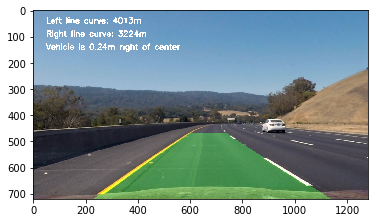

In [11]:
l = Line()
img = cv2.cvtColor(cv2.imread('test_images/test3.jpg'),cv2.COLOR_BGR2RGB)
result = l.pipeline(img)
plt.figure()
plt.imshow(result)
plt.show()

In [12]:
l = Line()
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(l.pipeline)

%time project_clip.write_videofile('result_project_video_2.mp4', audio=False)

[MoviePy] >>>> Building video result_project_video_2.mp4
[MoviePy] Writing video result_project_video_2.mp4


100%|█████████▉| 1260/1261 [06:24<00:00,  3.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_project_video_2.mp4 

CPU times: user 3min 52s, sys: 21.2 s, total: 4min 13s
Wall time: 6min 27s
